# Generational changes in religious affiliation

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)

from scipy.special import expit

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

In [2]:
# !wget https://gssdataexplorer.norc.org/extracts/21438/download

In [3]:
gss = utils.ReadGss('gss_religion_data')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Cleaning variables

In [4]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40129

In [5]:
utils.values(gss, 'god')

1.0      673
2.0     1110
3.0     2286
4.0      900
5.0     3662
6.0    13706
Name: god, dtype: int64

In [6]:
gss['atheist'] = (gss.god.isin([1]))
gss['agnostic'] = (gss.god.isin([2]))
gss['believe'] = (gss.god.isin([5, 6]))

In [7]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

In [8]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

In [9]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [10]:
gss.dropna(subset=['age', 'cohort', 'relig'], inplace=True)
gss.shape

(61995, 14)

We drop 471 records due to missing data.

In [11]:
62466 - 61995

471

Here's the distribution of ages.

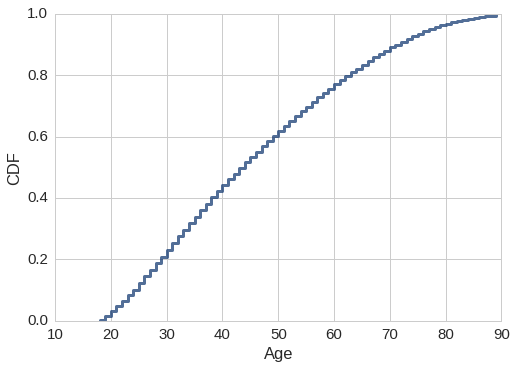

In [12]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [13]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5)

Here's the distribution of birth year.

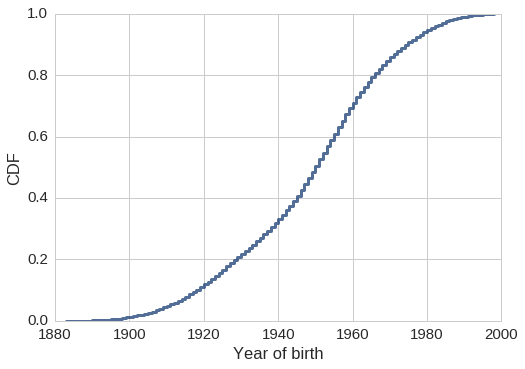

In [14]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [15]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5) + 2.5

In [16]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

Here's the distribution of religion codes.

In [17]:
utils.values(gss, 'relig')

1.0     35856
2.0     15136
3.0      1233
4.0      7231
5.0      1064
6.0       177
7.0        88
8.0        38
9.0       135
10.0      112
11.0      760
12.0       30
13.0      135
Name: relig, dtype: int64

Coding one-hots for 4 religious categories.

In [18]:
gss['none'] = (gss.relig==4).astype(int)
gss['cath'] = (gss.relig==2).astype(int)

# the second line lumps "Orthodox-Christian" and "Christian" with Protestant
gss['prot'] = (gss.relig==1).astype(int)
gss['prot'] = (gss.relig.isin([1,10,11])).astype(int)

gss['other'] = (gss.relig.isin([3,5,6,7,8,9,10,11,12,13])).astype(int)

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [19]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,atheist,agnostic,believe,age_group,cohort5,cohort10,none,cath,prot,other
0,1972,0,0,1917.0,55.0,0.8893,0,1.0,12,1176,...,False,False,False,55.0,1917.5,1910.0,0,0,1,0
1,1972,0,0,1905.0,67.0,0.8893,0,1.0,4,1341,...,False,False,False,65.0,1907.5,1900.0,0,0,1,0
2,1972,0,0,1921.0,51.0,0.8893,0,2.0,12,902,...,False,False,False,50.0,1922.5,1920.0,0,1,0,0
3,1972,0,0,1922.0,50.0,0.8893,0,1.0,12,1403,...,False,False,False,50.0,1922.5,1920.0,0,0,1,0
4,1972,0,0,1919.0,53.0,1.3339,0,5.0,8,854,...,False,False,False,50.0,1917.5,1910.0,0,0,0,1


## How does religious affiliation change with age?

Group by decade of birth and age group.

In [20]:
grouped = sample.groupby(['cohort10', 'age_group'])

Count the number of observations in each decade/age group.

In [21]:
counts = grouped.none.count().unstack()
counts

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,42.0
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,166.0,137.0,97.0
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,398.0,520.0,329.0,247.0,160.0
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,607.0,737.0,686.0,600.0,431.0,247.0,174.0
1920.0,NaN,NaN,NaN,NaN,NaN,86.0,758.0,991.0,922.0,911.0,728.0,597.0,433.0,272.0,191.0
1930.0,NaN,NaN,NaN,85.0,599.0,1008.0,930.0,974.0,795.0,732.0,637.0,487.0,387.0,155.0,17.0
1940.0,NaN,131.0,857.0,1171.0,1220.0,1359.0,1333.0,1139.0,1052.0,933.0,668.0,291.0,39.0,NaN,NaN
1950.0,331.0,1436.0,1600.0,1587.0,1708.0,1602.0,1596.0,1281.0,1123.0,541.0,81.0,NaN,NaN,NaN,NaN
1960.0,339.0,1549.0,1561.0,1611.0,1541.0,1477.0,1052.0,734.0,102.0,NaN,NaN,NaN,NaN,NaN,NaN


Compute the percentage of Nones in each group.

In [22]:
percent_none = grouped.none.mean().unstack()
percent_none

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,0.000000
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017857,0.042169,0.014599,0.020619
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.037688,0.044231,0.012158,0.032389,0.031250
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.079545,0.023064,0.020353,0.037901,0.041667,0.025522,0.056680,0.057471
1920.0,NaN,NaN,NaN,NaN,NaN,0.046512,0.031662,0.017154,0.035792,0.028540,0.045330,0.043551,0.064665,0.044118,0.041885
1930.0,NaN,NaN,NaN,0.082353,0.055092,0.042659,0.047312,0.035934,0.031447,0.049180,0.075353,0.073922,0.059432,0.116129,0.058824
1940.0,NaN,0.221374,0.106184,0.098207,0.089344,0.068433,0.078020,0.071115,0.088403,0.109325,0.109281,0.068729,0.076923,NaN,NaN
1950.0,0.123867,0.120474,0.121875,0.098299,0.101874,0.140449,0.125313,0.132709,0.149599,0.166359,0.135802,NaN,NaN,NaN,NaN
1960.0,0.162242,0.109103,0.110826,0.139044,0.163530,0.127285,0.163498,0.155313,0.205882,NaN,NaN,NaN,NaN,NaN,NaN


Drop cells where we have fewer than 50 observations.

In [23]:
percent_none[counts < 50] = np.nan

Select rows for people born in the 1930s through 1980s.

In [24]:
decades = np.linspace(1930, 1980, 6, endpoint=True)
percent_none.loc[decades]

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
cohort10,,,,,,,,,,,,,,,
1930.0,NaN,NaN,NaN,0.082353,0.055092,0.042659,0.047312,0.035934,0.031447,0.049180,0.075353,0.073922,0.059432,0.116129,NaN
1940.0,NaN,0.221374,0.106184,0.098207,0.089344,0.068433,0.078020,0.071115,0.088403,0.109325,0.109281,0.068729,NaN,NaN,NaN
1950.0,0.123867,0.120474,0.121875,0.098299,0.101874,0.140449,0.125313,0.132709,0.149599,0.166359,0.135802,NaN,NaN,NaN,NaN
1960.0,0.162242,0.109103,0.110826,0.139044,0.163530,0.127285,0.163498,0.155313,0.205882,NaN,NaN,NaN,NaN,NaN,NaN
1970.0,0.163043,0.197756,0.188489,0.217687,0.229268,0.236842,0.121622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980.0,0.231707,0.253685,0.294333,0.280335,0.259259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Choose some colors.

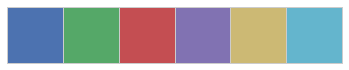

In [25]:
colors = sns.color_palette()
sns.palplot(colors)

For each birth cohort, plot the percentage of Nones as a function of age.

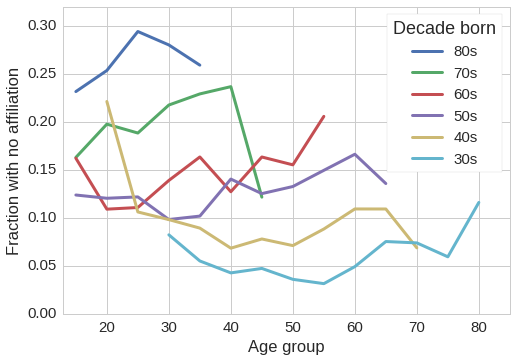

In [26]:
options = dict(alpha=1)

thinkplot.preplot(6)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.plot(percent_none.loc[1950], label='50s', color=colors[3], **options)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)

xlabel = 'Age group'
ylabel = 'Fraction with no affiliation'
axis = [13, 85, 0, 0.32]

thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, legend=True)
plt.gca().get_legend().set(title='Decade born');

Same as the previous, but as a multi-plot.

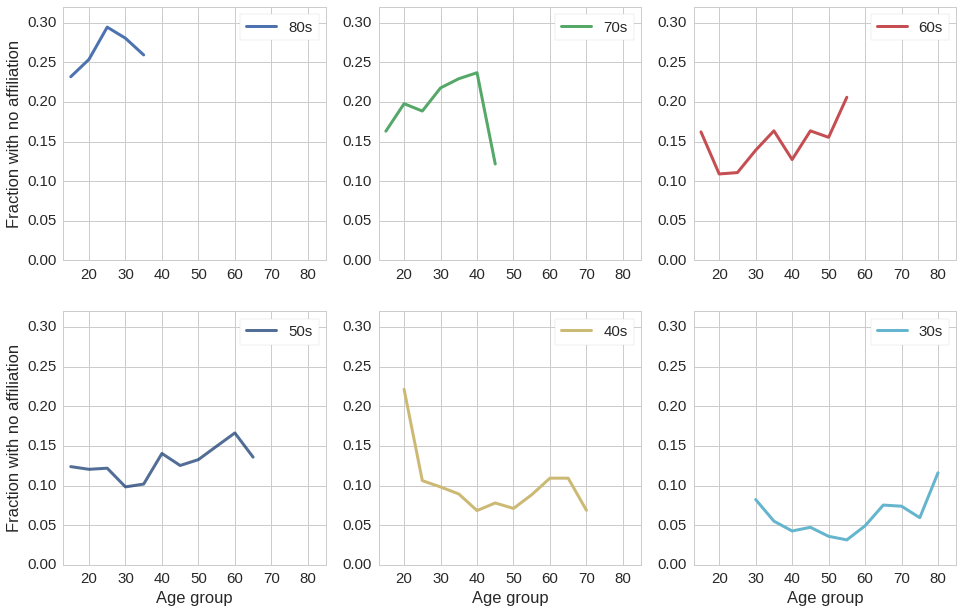

In [27]:
thinkplot.preplot(num=6, rows=2, cols=3)
thinkplot.subplot(1)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.config(ylabel=ylabel, axis=axis)

thinkplot.subplot(2)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(3)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(4)
thinkplot.plot(percent_none.loc[1950], label='50s')
thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, color=colors[3], **options)

thinkplot.subplot(5)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

thinkplot.subplot(6)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

## Generational replacement

Choose colors

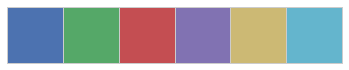

In [28]:
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')
sns.palplot(colors)

In [29]:
def plot_grouped(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    percent_other = grouped.other.mean() * 100
    percent_none = grouped.none.mean() * 100
    percent_prot = grouped.prot.mean() * 100
    percent_cath = grouped.cath.mean() * 100
    
    thinkplot.plot(percent_prot, color=ORANGE, label='Protestant')
    thinkplot.plot(percent_cath, color=GREEN, label='Catholic')
    thinkplot.plot(percent_none, color=RED, label='None')
    thinkplot.plot(percent_other, color=BLUE, label='Other')

Plot the percentage in each religious group as a function of interview year.

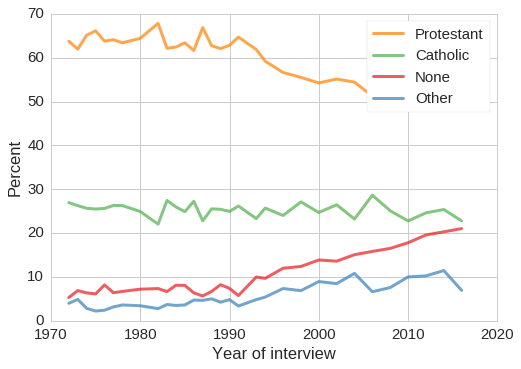

In [30]:
grouped1 = sample.groupby(['year'])
plot_grouped(grouped1)
thinkplot.config(xlabel='Year of interview', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

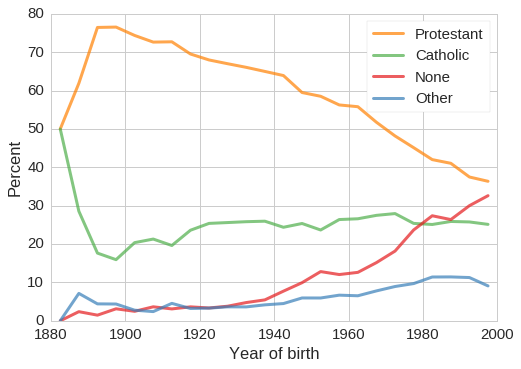

In [31]:
grouped2 = sample.groupby(['cohort5'])
plot_grouped(grouped2)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

##  Modeling

Before running models, center the factors we're planning to use.

In [32]:
def center_factors(df):
    """Center factors around their means.
    
    df: DataFrame
    """
    df['cohort66'] = df.cohort - 1966
    df['cohort662'] = df.cohort66**2

In [33]:
center_factors(sample)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,believe,age_group,cohort5,cohort10,none,cath,prot,other,cohort66,cohort662
0,1972,0,0,1917.0,55.0,0.8893,0,1.0,12,1176,...,False,55.0,1917.5,1910.0,0,0,1,0,-49.0,2401.0
1,1972,0,0,1905.0,67.0,0.8893,0,1.0,4,1341,...,False,65.0,1907.5,1900.0,0,0,1,0,-61.0,3721.0
2,1972,0,0,1921.0,51.0,0.8893,0,2.0,12,902,...,False,50.0,1922.5,1920.0,0,1,0,0,-45.0,2025.0
3,1972,0,0,1922.0,50.0,0.8893,0,1.0,12,1403,...,False,50.0,1922.5,1920.0,0,0,1,0,-44.0,1936.0
4,1972,0,0,1919.0,53.0,1.3339,0,5.0,8,854,...,False,50.0,1917.5,1910.0,0,0,0,1,-47.0,2209.0


Run logistic regression to fit models to each religious group.

In [34]:
formula = 'prot ~ cohort66 + cohort662'
results1 = smf.logit(formula, data=sample).fit()
results1.summary()

Optimization terminated successfully.
         Current function value: 0.663488
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 May 2017   Pseudo R-squ.:                 0.02220
Time:                        17:04:06   Log-Likelihood:                -41133.
converged:                       True   LL-Null:                       -42067.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0801      0.010      7.660      0.000       0.060       0.101
cohort66      -0.0209      0.001    -29.183      0.000      -0.022      -0.019
cohort662     -0.0001   1.58e-05     -6.345      0.000      -0.000   -6.93e-05
==============================================================================
"""

In [35]:
formula = 'cath ~ cohort66 + cohort662'
results2 = smf.logit(formula, data=sample).fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.565458
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 May 2017   Pseudo R-squ.:               0.0007958
Time:                        17:04:06   Log-Likelihood:                -35056.
converged:                       True   LL-Null:                       -35083.
                                        LLR p-value:                 7.487e-13
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0300      0.012    -87.496      0.000      -1.053      -1.007
cohort66       0.0002      0.001      0.297      0.767      -0.001       0.002
cohort662  -6.871e-05   1.75e-05     -3.925      0.000      -0.000   -3.44e-05
==============================================================================
"""

In [36]:
formula = 'other ~ cohort66 + cohort662'
results3 = smf.logit(formula, data=sample).fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.226027
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 May 2017   Pseudo R-squ.:                 0.01779
Time:                        17:04:06   Log-Likelihood:                -14013.
converged:                       True   LL-Null:                       -14266.
                                        LLR p-value:                6.327e-111
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5045      0.020   -124.905      0.000      -2.544      -2.465
cohort66       0.0213      0.001     17.133      0.000       0.019       0.024
cohort662    8.87e-05   3.23e-05      2.750      0.006    2.55e-05       0.000
==============================================================================
"""

In [37]:
formula = 'none ~ cohort66 + cohort662'
results4 = smf.logit(formula, data=sample).fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.333931
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 May 2017   Pseudo R-squ.:                 0.06174
Time:                        17:04:07   Log-Likelihood:                -20702.
converged:                       True   LL-Null:                       -22064.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6581      0.015   -108.653      0.000      -1.688      -1.628
cohort66       0.0347      0.001     37.328      0.000       0.033       0.037
cohort662   1.541e-08   2.85e-05      0.001      1.000   -5.59e-05    5.59e-05
==============================================================================
"""

Use a fitted model to make a prediction.

In [38]:
def make_pred(results):
    """Make a prediction based on a fitted model.
    
    results: RegressionResults object
    
    returns: Series that maps datas to predicted percentages
    """
    cohort = np.arange(1997, 2020)
    df = pd.DataFrame(dict(cohort=cohort))
    center_factors(df)
    pred = results.predict(df) * 100
    pred.index = cohort
    return pred

Plot predictions.

In [39]:
def plot_predictions(series_seq):
    """Plot a sequence of series.
    
    series_seq: list of series
    """
    alpha = 0.3
    colors = ['ORANGE', 'GREEN', 'BLUE', 'RED']
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)

## Generational replacement

Predict future generations based on the models.

In [40]:
COLUMNS = ['prot', 'cath', 'other', 'none']

def run_models(sample, result_seq, year, verbose=False):
    """Simulate future samples.
    
    sample: DataFrame, one row per respondent
    result_seq: list of RegressionResult objects
    year: number
    verbose: boolean, whether to print diagnostic info
    
    returns: Series that maps from religion to percentage
    """
    age = thinkstats2.Resample(sample.age)
    cohort = year - age
    if verbose:
        # print the fraction of people in the simulated sample
        # who were actually observed
        print(np.mean(cohort<1997))

    df = pd.DataFrame(dict(cohort=cohort))
    center_factors(df)
    pred = [results.predict(df).mean() for results in result_seq]
    return pd.Series(pred, index=COLUMNS) * 100

In [41]:
run_models(sample, [results1, results2, results3, results4], 2016)

prot     48.419490
cath     25.910228
other     9.054950
none     20.252926
dtype: float64

In [42]:
run_models(sample, [results1, results2, results3, results4], 2023)

prot     44.634577
cath     25.779548
other    10.494087
none     24.222906
dtype: float64

In [43]:
run_models(sample, [results1, results2, results3, results4], 2037)

prot     36.770025
cath     25.152433
other    14.253596
none     33.457205
dtype: float64

In [44]:
run_models(sample, [results1, results2, results3, results4], 2053)

prot     27.602203
cath     23.832103
other    20.605832
none     45.897556
dtype: float64

In [45]:
result_seq = [results1, results2, results3, results4]
df = pd.DataFrame(columns=COLUMNS)

for year in range(2016, 2050):
    df.loc[year] = run_models(sample, result_seq, year)

In [46]:
df

,prot,cath,other,none
2016,48.361950,25.909586,9.073373,20.308123
2017,47.888960,25.898686,9.245325,20.791790
2018,47.312400,25.884737,9.454899,21.381386
2019,46.787845,25.865895,9.653329,21.932177
2020,46.226315,25.848133,9.864087,22.516820
2021,45.693482,25.827119,10.071584,23.082844
2022,45.164920,25.804084,10.281414,23.650587
2023,44.591662,25.776532,10.513468,24.273027
2024,44.037053,25.749327,10.738915,24.875587
2025,43.473904,25.715070,10.979388,25.505551


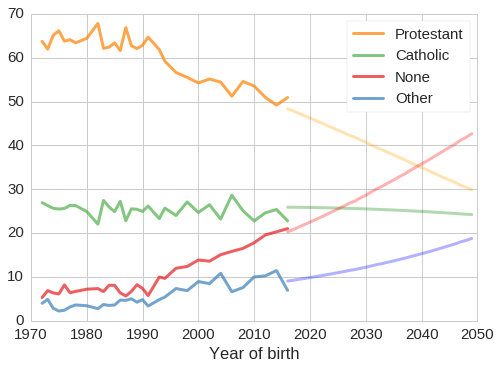

In [47]:
plot_predictions([df.prot, df.cath, df.other, df.none])

plot_grouped(grouped1)
thinkplot.config(xlabel='Year of birth')

In [48]:
recent = sample.loc[sample.year >= 2008].copy()

In [49]:
def plot_beliefs(grouped):
    df = pd.DataFrame(columns=['atheist', 'agnostic', 'believe'])
    df['atheist'] = grouped.atheist.mean()
    df['agnostic'] = grouped.agnostic.mean()
    df['believe'] = grouped.believe.mean()

    df[df == 0.0] = np.nan
    df *= 100
    df.plot()

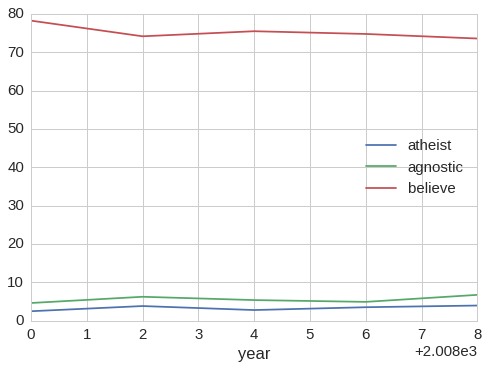

In [50]:
grouped = recent.groupby('year')
plot_beliefs(grouped)

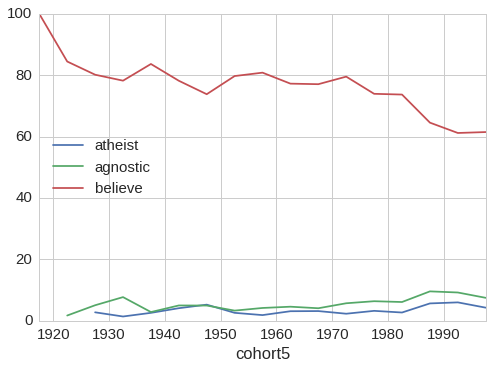

In [51]:
grouped = recent.groupby('cohort5')
plot_beliefs(grouped)

## Older explorations

In [52]:
def percent_relig(df):
    """Compute the fraction in each major religious group.
    
    df: DataFrame
    
    returns: Series that maps from group name to percent.
    """
    return df[['prot', 'cath', 'other', 'none']].mean()

In [53]:
percent_relig(sample[sample.year==2016])

prot     0.509334
cath     0.227897
other    0.069391
none     0.210285
dtype: float64

In [54]:
recent = sample.loc[sample.year>=2000].copy()
recent.shape

(24146, 23)

In [55]:
percent_relig(recent)

prot     0.526008
cath     0.251719
other    0.087882
none     0.168641
dtype: float64

In [56]:
recent.year.mean()

2007.6164996272676

{'xscale': 'linear', 'yscale': 'linear'}

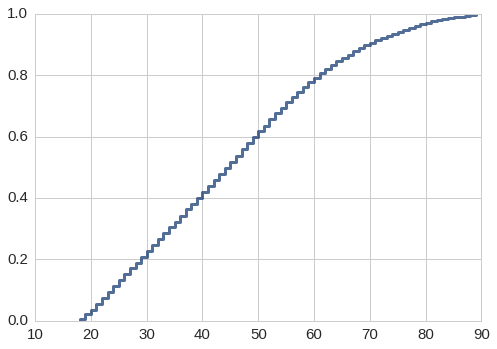

In [57]:
thinkplot.Cdf(thinkstats2.Cdf(recent.age))

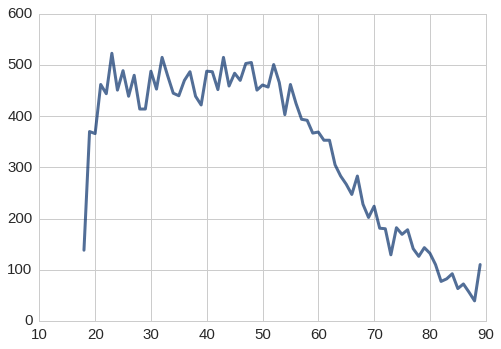

In [58]:
hist = thinkstats2.Hist(recent.age)
thinkplot.Pdf(hist)

In [59]:
def advance(df):
    """Ages a cohort by 1 year.
    
    df: DataFrame
    
    returns: new DataFrame
    """
    new = df.copy()
    new.year += 1
    new.age += 1
    
    return new

In [60]:
df = recent
pr = percent_relig(recent)
series = pd.DataFrame(columns=pr.index)

for _ in range(10):
    df = advance(df)
    year = df.year.mean()
    series.loc[year] = percent_relig(df)

In [61]:
series

,prot,cath,other,none
2008.6165,0.526008,0.251719,0.087882,0.168641
2009.6165,0.526008,0.251719,0.087882,0.168641
2010.6165,0.526008,0.251719,0.087882,0.168641
2011.6165,0.526008,0.251719,0.087882,0.168641
2012.6165,0.526008,0.251719,0.087882,0.168641
2013.6165,0.526008,0.251719,0.087882,0.168641
2014.6165,0.526008,0.251719,0.087882,0.168641
2015.6165,0.526008,0.251719,0.087882,0.168641
2016.6165,0.526008,0.251719,0.087882,0.168641
2017.6165,0.526008,0.251719,0.087882,0.168641


In [62]:
updated = advance(recent)

In [63]:
# https://www.cdc.gov/nchs/data/dvs/mortfinal2007_worktable23r.pdf

AGES = np.array([24, 34, 44, 54, 64, 74, 84])
RATES = np.array([79.9, 104.9, 184.4, 420.9, 877.7, 2011.3, 5011.6, 12946.5]) / 100000

In [64]:
def choose_dead(df):
    """Simulate deaths based on age-related rates.
    
    df: DataFrame
    
    returns: boolean array with True for dead
    """
    
    # look up the death rate for each respondent
    indices = np.searchsorted(AGES, df.age)
    rates = RATES[indices]
    
    # choose who dies
    dead = np.random.random(len(rates)) < rates
    return dead

In [65]:
dead = choose_dead(updated)
dead.sum()

242

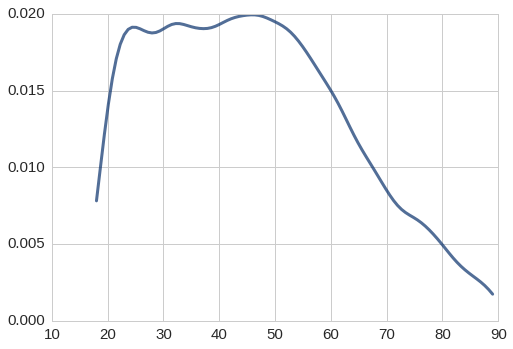

In [66]:
pdf = thinkstats2.EstimatedPdf(recent.age)
thinkplot.Pdf(pdf)

In [67]:
def replace(df, pdf):
    updated = advance(df)
    dead = choose_dead(updated)
    updated.loc[dead, 'age'] = np.nan
    
    pdf2 = thinkstats2.EstimatedPdf(updated.age.dropna())
    ages = np.arange(17, 92, 1)
    diffs = pdf.Density(ages) - pdf2.Density(ages)
    diffs[diffs<0] = 0
    pmf = thinkstats2.Pmf(dict(zip(ages, diffs)))
    thinkplot.Pdf(pmf)
    replacement_ages = pmf.Sample(dead.sum())
    updated.loc[dead, 'age'] = replacement_ages
    
    return updated

In [68]:
def replace(df, pmf):
    updated = advance(df)
    dead = choose_dead(updated)
    updated.loc[dead, 'age'] = 18
    updated['weight'] = pmf.Probs(updated.age.values)
    sample = thinkstats2.ResampleRowsWeighted(updated, column='weight')
    return sample

In [69]:
pmf = thinkstats2.Pmf(recent.age)

In [70]:
updated = replace(recent, pmf)
updated.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,age_group,cohort5,cohort10,none,cath,prot,other,cohort66,cohort662,weight
58565,2015,0,3,1988.0,27.0,0.896003,1,4.0,12,287,...,25.0,1987.5,1980.0,1,0,0,0,22.0,484.0,0.019879
42830,2003,0,0,1953.0,50.0,1.115600,2,1.0,12,356,...,45.0,1952.5,1950.0,0,0,1,0,-13.0,169.0,0.019092
37876,2001,3,0,1982.0,19.0,1.647800,3,4.0,11,338,...,15.0,1982.5,1980.0,1,0,0,0,16.0,256.0,0.015323
57885,2015,0,3,1981.0,34.0,0.896003,1,5.0,12,1629,...,30.0,1982.5,1980.0,0,0,0,1,15.0,225.0,0.018430
39346,2001,1,1,1975.0,26.0,1.098500,3,1.0,17,2399,...,25.0,1977.5,1970.0,0,0,1,0,9.0,81.0,0.018181


In [71]:
updated = replace(updated, pmf)

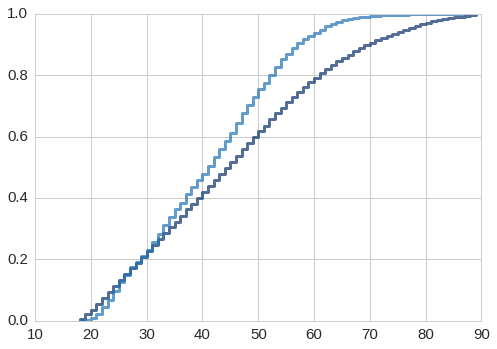

In [72]:
cdf1 = thinkstats2.Cdf(recent.age)
cdf2 = thinkstats2.Cdf(updated.age)
thinkplot.Cdfs([cdf1, cdf2])

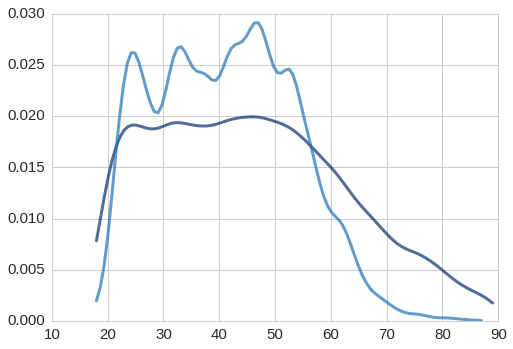

In [73]:
pdf1 = thinkstats2.EstimatedPdf(recent.age)
pdf2 = thinkstats2.EstimatedPdf(updated.age)
thinkplot.Pdfs([pdf1, pdf2])

In [74]:
xs = np.arange(17, 92, 1)
xs

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91])